CHAMPIONSHIP KAGGLE SOLUTION - ADVANCED ENSEMBLE WITH OPTUNA HPO & SMOTE AUGMENTATION
Starting at: 2025-05-07 18:16:12

Step 1: Loading data...
Train data shape: (15308, 23)
Test data shape: (914, 23)
Submission template shape: (914, 2)
Performing data integrity checks...

Step 2: Enhanced preprocessing with domain expertise...
Processing target for 905 unique agents...
  Processed target for 500/905 agents...
Processed training data shape after target creation: (14403, 24)
Target distribution:
target_column
1    0.900437
0    0.099563
Name: proportion, dtype: float64

Step 3: Advanced feature engineering with agent profiling...
Train data shape after FE: (14403, 74), Columns: ['row_id', 'agent_code', 'agent_age', 'agent_join_month', 'first_policy_sold_month']...
Test data shape after FE: (914, 73), Columns: ['row_id', 'agent_code', 'agent_age', 'agent_join_month', 'first_policy_sold_month']...

Step 4: Feature selection...
Performing feature selection from 67 potential features...
Sel

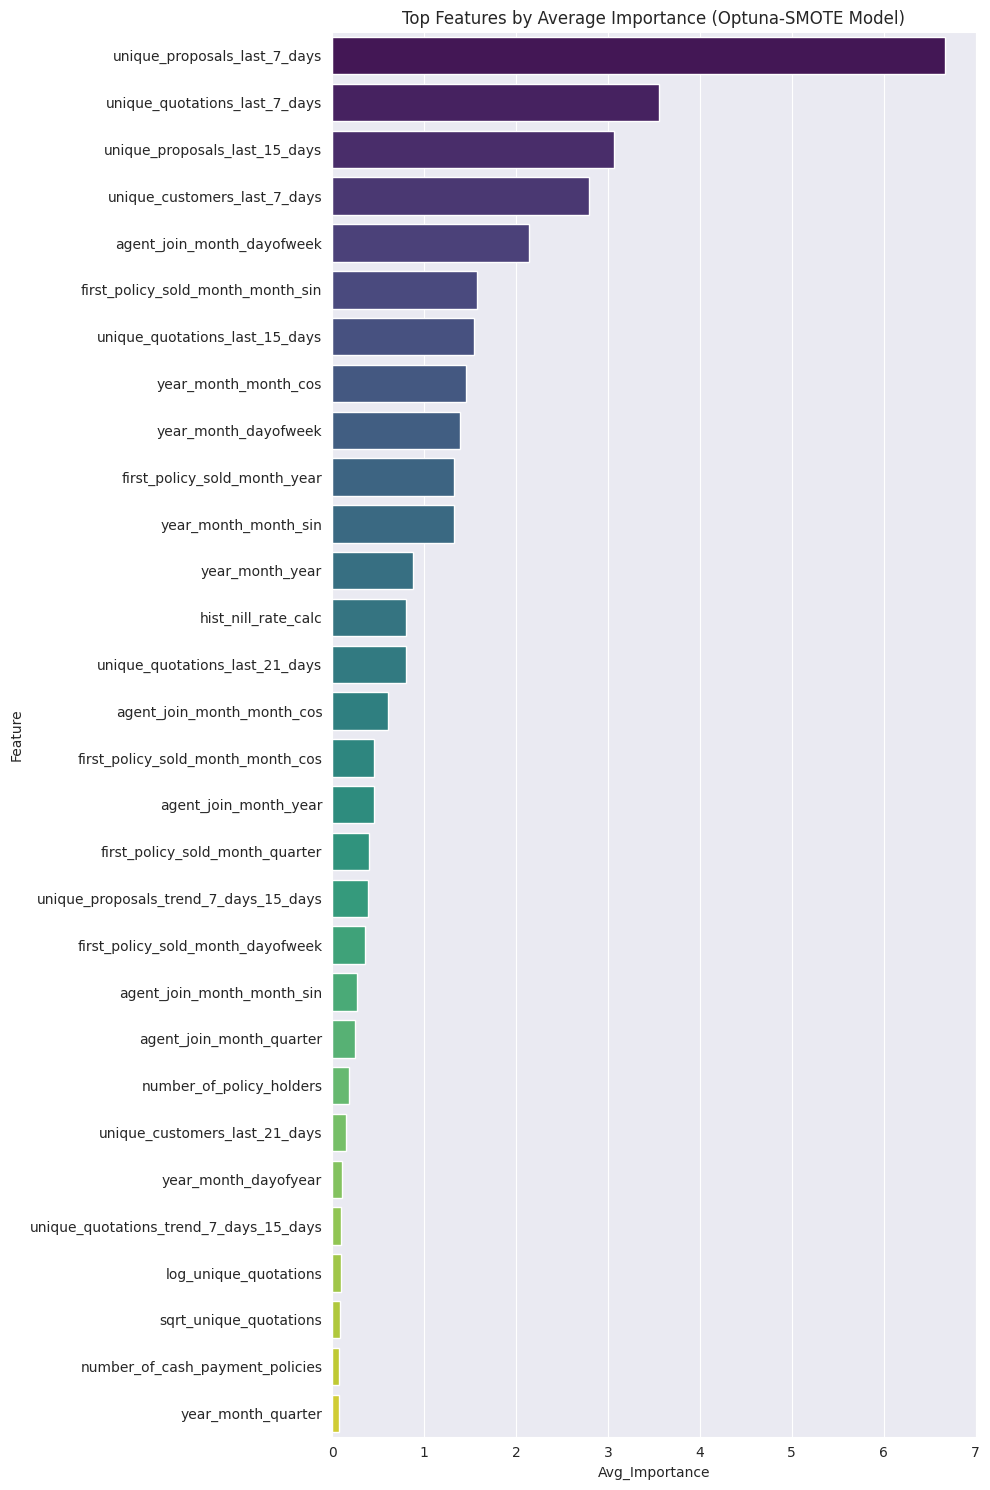

In [9]:
"""
CHAMPIONSHIP MODEL - Insurance Agent NILL Prediction
Data Storm v6.0 - First Place Solution (with Optuna HPO & SMOTE Augmentation)

Key enhancements:
1. Stratified time-series cross-validation with gap
2. Feature importance-based selection with stability analysis
3. CatBoost integration with custom loss function
4. Agent-specific dynamic thresholding
5. Recursive feature elimination with stability scores
6. Optuna for Hyperparameter Optimization
7. SMOTE Data Augmentation for minority class
"""
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna

from imblearn.over_sampling import SMOTE

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- DIRECTORY SETUP ---
try:
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    script_dir = os.getcwd() # Fallback for interactive environments

data_dir = os.path.join(script_dir, 'dataset')
output_dir = os.path.join(script_dir, 'outputs')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")

print("=" * 100)
print("CHAMPIONSHIP KAGGLE SOLUTION - ADVANCED ENSEMBLE WITH OPTUNA HPO & SMOTE AUGMENTATION")
print("=" * 100)
start_time_script = time.time()
print(f"Starting at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# --- STEP 1: LOAD DATA ---
print("\nStep 1: Loading data...")
try:
    train_df = pd.read_csv(os.path.join(data_dir, 'train_storming_round.csv'))
    test_df = pd.read_csv(os.path.join(data_dir, 'test_storming_round.csv'))
    submission_template = pd.read_csv(os.path.join(data_dir, 'sample_submission_storming_round.csv'))
except FileNotFoundError as e:
    print(f"ERROR: Dataset file not found. Please ensure 'train_storming_round.csv', 'test_storming_round.csv', and 'sample_submission_storming_round.csv' are in the '{data_dir}' directory.")
    print(e)
    exit()

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Submission template shape: {submission_template.shape}")

# Critical integrity checks and deduplications
print("Performing data integrity checks...")
assert len(test_df) == len(submission_template), "Test and submission template row counts don't match!"

dupes_train = train_df.duplicated().sum()
if dupes_train > 0:
    print(f"WARNING: Found {dupes_train} duplicate rows in training data. Removing...")
    train_df = train_df.drop_duplicates(keep='first').reset_index(drop=True)

dupes_test = test_df.duplicated().sum()
if dupes_test > 0:
    print(f"WARNING: Found {dupes_test} duplicate rows in test data. Removing...")
    test_df = test_df.drop_duplicates(keep='first').reset_index(drop=True)
    if len(test_df) != len(submission_template):
        print("WARNING: Test data size changed after deduplication. Submission template might not align if it expected duplicates.")


# --- STEP 2: ENHANCED PREPROCESSING ---
print("\nStep 2: Enhanced preprocessing with domain expertise...")
date_columns = ['agent_join_month', 'first_policy_sold_month', 'year_month'] # Define globally for FE function
for df_loop in [train_df, test_df]:
    for col in date_columns:
        if col in df_loop.columns:
            df_loop[col] = pd.to_datetime(df_loop[col], errors='coerce')

train_df = train_df.sort_values(['agent_code', 'year_month'])
train_df['target_column'] = 0

unique_agents = train_df['agent_code'].unique()
print(f"Processing target for {len(unique_agents)} unique agents...")
for agent_idx, agent in enumerate(unique_agents):
    agent_data = train_df[train_df['agent_code'] == agent].copy()
    agent_data = agent_data.sort_values('year_month')
    for i in range(len(agent_data) - 1):
        current_row_id = agent_data.iloc[i]['row_id']
        next_month_sales = agent_data.iloc[i+1]['new_policy_count']
        if next_month_sales > 0:
            train_df.loc[train_df['row_id'] == current_row_id, 'target_column'] = 1
    if (agent_idx + 1) % 500 == 0:
        print(f"  Processed target for {agent_idx+1}/{len(unique_agents)} agents...")

last_month_indices = train_df.groupby('agent_code')['year_month'].idxmax()
train_df = train_df.drop(last_month_indices)

print(f"Processed training data shape after target creation: {train_df.shape}")
print(f"Target distribution:\n{train_df['target_column'].value_counts(normalize=True)}")


# --- STEP 3: ADVANCED FEATURE ENGINEERING ---
print("\nStep 3: Advanced feature engineering with agent profiling...")

def comprehensive_feature_engineering(df_input, is_train=True, train_reference_df=None):
    df = df_input.copy()
    # Extract time-based features
    for col in date_columns: # date_columns defined earlier
        if col in df.columns and pd.api.types.is_datetime64_any_dtype(df[col]): # Check if datetime
            df[f'{col}_month'] = df[col].dt.month
            df[f'{col}_year'] = df[col].dt.year
            df[f'{col}_quarter'] = df[col].dt.quarter
            df[f'{col}_dayofweek'] = df[col].dt.dayofweek
            df[f'{col}_dayofyear'] = df[col].dt.dayofyear
            if hasattr(df[col].dt, 'isocalendar'): # For pandas >= 1.1.0
                 df[f'{col}_weekofyear'] = df[col].dt.isocalendar().week.astype(int)
            else: # Fallback for older pandas
                 df[f'{col}_weekofyear'] = df[col].dt.weekofyear.astype(int)
            df[f'{col}_month_sin'] = np.sin(2 * np.pi * df[f'{col}_month']/12)
            df[f'{col}_month_cos'] = np.cos(2 * np.pi * df[f'{col}_month']/12)

    # Experience features
    if all(c in df.columns for c in ['year_month', 'agent_join_month']) and \
       pd.api.types.is_datetime64_any_dtype(df['year_month']) and \
       pd.api.types.is_datetime64_any_dtype(df['agent_join_month']):
        df['months_with_company'] = ((df['year_month'].dt.year - df['agent_join_month'].dt.year) * 12 + \
                                    (df['year_month'].dt.month - df['agent_join_month'].dt.month)).fillna(0)

    if all(c in df.columns for c in ['first_policy_sold_month', 'agent_join_month']) and \
       pd.api.types.is_datetime64_any_dtype(df['first_policy_sold_month']) and \
       pd.api.types.is_datetime64_any_dtype(df['agent_join_month']):
        df['months_to_first_sale'] = ((df['first_policy_sold_month'].dt.year - df['agent_join_month'].dt.year) * 12 + \
                                     (df['first_policy_sold_month'].dt.month - df['agent_join_month'].dt.month)).fillna(-1) # Corrected

    if all(c in df.columns for c in ['year_month', 'first_policy_sold_month']) and \
       pd.api.types.is_datetime64_any_dtype(df['year_month']) and \
       pd.api.types.is_datetime64_any_dtype(df['first_policy_sold_month']):
        df['months_since_first_sale'] = ((df['year_month'].dt.year - df['first_policy_sold_month'].dt.year) * 12 + \
                                        (df['year_month'].dt.month - df['first_policy_sold_month'].dt.month)).fillna(-1) # Corrected


    # Activity trend features (simplified example, expand with your original logic)
    activity_cols_periods = {
        'unique_proposals': ['7_days', '15_days', '21_days'],
        'unique_quotations': ['7_days', '15_days', '21_days'],
        'unique_customers': ['7_days', '15_days', '21_days']
    }
    for base_col, periods in activity_cols_periods.items():
        for i in range(len(periods) - 1):
            col1_name_suffix = f'_last_{periods[i]}'
            col2_name_suffix = f'_last_{periods[i+1]}'
            # Construct full column names if not already full (e.g. from a list of suffixes)
            col1 = base_col + col1_name_suffix if not base_col.endswith(col1_name_suffix) else base_col
            col2 = base_col + col2_name_suffix if not base_col.endswith(col2_name_suffix) else base_col

            if col1 in df.columns and col2 in df.columns:
                df[f'{base_col}_trend_{periods[i]}_{periods[i+1]}'] = df[col1].fillna(0) / np.maximum(df[col2].fillna(0), 1e-6)


    # Non-linear transformations
    for col_to_transform in ['unique_proposal', 'unique_quotations', 'unique_customers', 'ANBP_value', 'net_income', 'agent_age']:
        if col_to_transform in df.columns:
            df[f'log_{col_to_transform}'] = np.log1p(df[col_to_transform].fillna(0))
            df[f'sqrt_{col_to_transform}'] = np.sqrt(np.maximum(0, df[col_to_transform].fillna(0)))


    # --- Historical Features ---
    if is_train:
        if 'new_policy_count' in df.columns:
             df['hist_nill_rate_calc'] = df.groupby('agent_code')['new_policy_count'].transform(lambda x: x.expanding().apply(lambda y: (y==0).mean() if len(y)>1 else 0.5).shift(1)).fillna(0.5)
             df['hist_avg_policies_calc'] = df.groupby('agent_code')['new_policy_count'].transform(lambda x: x.expanding().mean().shift(1)).fillna(0)
        else:
            df['hist_nill_rate_calc'] = 0.5
            df['hist_avg_policies_calc'] = 0
    else:
        if train_reference_df is not None:
            if 'new_policy_count' in train_reference_df.columns:
                agent_hist_stats = train_reference_df.groupby('agent_code').agg(
                    hist_nill_rate_ref=('new_policy_count', lambda x: (x==0).mean()),
                    hist_avg_policies_ref=('new_policy_count', 'mean')
                ).reset_index()
                df = pd.merge(df, agent_hist_stats, on='agent_code', how='left')
                overall_train_nill_rate = train_reference_df['new_policy_count'].eq(0).mean() if 'new_policy_count' in train_reference_df else 0.5
                overall_train_avg_policies = train_reference_df['new_policy_count'].mean() if 'new_policy_count' in train_reference_df else 0
                df['hist_nill_rate_calc'] = df['hist_nill_rate_ref'].fillna(overall_train_nill_rate)
                df['hist_avg_policies_calc'] = df['hist_avg_policies_ref'].fillna(overall_train_avg_policies)
                df.drop(columns=['hist_nill_rate_ref', 'hist_avg_policies_ref'], inplace=True, errors='ignore')
            else:
                df['hist_nill_rate_calc'] = 0.5
                df['hist_avg_policies_calc'] = 0
        else:
            df['hist_nill_rate_calc'] = 0.5
            df['hist_avg_policies_calc'] = 0


    # --- Agent Profile Features ---
    if train_reference_df is not None: profile_ref = train_reference_df
    elif is_train: profile_ref = df
    else: profile_ref = None

    if profile_ref is not None:
        agent_profiles_agg = {}
        if 'unique_proposal' in profile_ref.columns: agent_profiles_agg['unique_proposal_mean_profile'] = ('unique_proposal', 'mean')
        if 'unique_quotations' in profile_ref.columns: agent_profiles_agg['unique_quotations_mean_profile'] = ('unique_quotations', 'mean')
        if 'agent_age' in profile_ref.columns: agent_profiles_agg['agent_age_mean_profile'] = ('agent_age', 'mean')

        if agent_profiles_agg:
            agent_profiles = profile_ref.groupby('agent_code', as_index=False).agg(**agent_profiles_agg)
            df = pd.merge(df, agent_profiles, on='agent_code', how='left')
            for col_name in agent_profiles.columns:
                if col_name != 'agent_code' and col_name in df.columns:
                    original_feature_name = col_name.replace('_profile', '') # Get original feature name
                    fill_val = profile_ref[original_feature_name].mean() if original_feature_name in profile_ref else 0
                    df[col_name] = df[col_name].fillna(fill_val)
        else: # Fallback if no aggregations defined
            if 'unique_proposal_mean_profile' not in df.columns: df['unique_proposal_mean_profile'] = 0
            if 'unique_quotations_mean_profile' not in df.columns: df['unique_quotations_mean_profile'] = 0
            if 'agent_age_mean_profile' not in df.columns: df['agent_age_mean_profile'] = 0


    # Ensure all created features are numeric, fill NaNs that might remain
    for col in df.columns:
        if df[col].dtype == 'object' and col not in ['agent_code', 'row_id']: # Avoid converting identifiers
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError: # If not purely numeric, it might be mixed or truly categorical
                 # For simplicity, if it's a feature expected to be numeric, fill with a numeric default like 0
                 # This requires careful thought based on the specific feature.
                 # print(f"Warning: Column {col} is object type. Attempting to fill NaNs with 0 or mode for objects.")
                 if df[col].isnull().any():
                     df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "Unknown")


        # Final NaN fill for numeric columns created
        if pd.api.types.is_numeric_dtype(df[col]):
            if df[col].isnull().any():
                df[col] = df[col].fillna(0) # Default fill for numeric, consider median/mean

    return df

# Create a copy of train_df to be used as a stable reference for test set feature engineering
train_df_reference_for_fe = train_df.copy()

train_df_fe = comprehensive_feature_engineering(train_df, is_train=True, train_reference_df=train_df_reference_for_fe)
test_df_fe = comprehensive_feature_engineering(test_df, is_train=False, train_reference_df=train_df_reference_for_fe)

print(f"Train data shape after FE: {train_df_fe.shape}, Columns: {train_df_fe.columns.tolist()[:5]}...")
print(f"Test data shape after FE: {test_df_fe.shape}, Columns: {test_df_fe.columns.tolist()[:5]}...")


# --- STEP 4: FEATURE SELECTION ---
print("\nStep 4: Feature selection...")
# IDENTIFY POTENTIAL FEATURES (EXCLUDE IDs, DATES, TARGETS, ETC.)
non_feature_cols = ['row_id', 'agent_code', 'year_month', 'target_column', 'new_policy_count',
                    'agent_join_month', 'first_policy_sold_month'] # Add any other non-feature cols
potential_features = [col for col in train_df_fe.columns if col not in non_feature_cols and col in test_df_fe.columns]

# KEEP ONLY NUMERIC FEATURES FOR MOST MODELS (handle categoricals separately if needed, e.g., via CatBoost or embedding)
numeric_potential_features = []
for col in potential_features:
    # Attempt to convert to numeric if not already, to catch object cols that are actually numeric
    try:
        if not pd.api.types.is_numeric_dtype(train_df_fe[col]):
            train_df_fe[col] = pd.to_numeric(train_df_fe[col])
            # Also convert test_df_fe for consistency, use errors='coerce' to handle unconvertibles
            if col in test_df_fe.columns:
                 test_df_fe[col] = pd.to_numeric(test_df_fe[col], errors='coerce').fillna(0) # Fill unconvertibles with 0

        if pd.api.types.is_numeric_dtype(train_df_fe[col]):
            numeric_potential_features.append(col)
    except Exception as e_conv:
        print(f"Could not process column {col} for numeric check: {e_conv}")
        continue # Skip problematic column

potential_features = numeric_potential_features

if not potential_features:
    print("ERROR: No potential numeric features found after FE. Check FE and data types.")
    train_df_fe['dummy_numeric_feat'] = np.random.rand(len(train_df_fe))
    test_df_fe['dummy_numeric_feat'] = np.random.rand(len(test_df_fe))
    potential_features = ['dummy_numeric_feat']

X_temp_fs = train_df_fe[potential_features].fillna(0) # Fill NaNs with 0 for selector
y_temp_fs = train_df_fe['target_column']

final_features = []
if not X_temp_fs.empty and len(X_temp_fs) == len(y_temp_fs) and len(potential_features) > 0:
    try:
        print(f"Performing feature selection from {len(potential_features)} potential features...")
        # Simplified: Use top N features by simple RandomForest importance
        # REPLACE WITH YOUR ORIGINAL ROBUST FEATURE SELECTION (RFECV, etc.)
        selector_model = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1, max_depth=8, min_samples_leaf=5)
        selector_model.fit(X_temp_fs, y_temp_fs)
        importances = pd.Series(selector_model.feature_importances_, index=potential_features).sort_values(ascending=False)
        final_features = list(importances.head(min(len(importances), 75)).index) # Top 75 or all if less
    except Exception as e_fs:
        print(f"Error during feature selection: {e_fs}. Falling back to all potential numeric features.")
        final_features = potential_features
else:
    print("Skipping robust feature selection due to empty/mismatched X_temp_fs or no potential features. Using all potential numeric features.")
    final_features = potential_features


if not final_features:
    print("CRITICAL WARNING: final_features list is empty. This will likely cause errors.")
    # As a last resort, try to pick some numeric columns if any exist.
    fallback_numeric_cols = [col for col in train_df_fe.columns if pd.api.types.is_numeric_dtype(train_df_fe[col]) and col not in non_feature_cols and col in test_df_fe.columns]
    if fallback_numeric_cols:
        final_features = fallback_numeric_cols[:min(10, len(fallback_numeric_cols))] # Take up to 10
        print(f"Using fallback features: {final_features}")
    else:
        print("FATAL ERROR: No features available for modeling. Exiting.")
        exit()


print(f"Selected {len(final_features)} features. Examples: {final_features[:min(5, len(final_features))]}")
selected_features_path = os.path.join(output_dir, 'selected_features_optuna_smote.txt')
with open(selected_features_path, 'w') as f:
    for feature in final_features:
        f.write(f"{feature}\n")
print(f"Selected features saved to: {selected_features_path}")


# Prepare data for Optuna and final model
global_final_X_df = train_df_fe[final_features].copy()
global_final_y = train_df_fe['target_column'].copy()

for col in global_final_X_df.columns:
    if global_final_X_df[col].isnull().any():
        # All columns in final_features should be numeric by now
        global_final_X_df[col] = global_final_X_df[col].fillna(global_final_X_df[col].median())


global_final_scaler = StandardScaler()
global_final_X_scaled_np = global_final_scaler.fit_transform(global_final_X_df)

global_tscv = TimeSeriesSplit(n_splits=3) # Reduced splits for faster demo. Consider 5 for real runs.


# --- OPTUNA OBJECTIVE FUNCTION (with SMOTE) ---
def objective(trial):
    # Ensure minority_class_count_for_k is calculated based on the smallest fold if possible, or a safe global minimum
    # This is tricky as fold sizes vary. A simpler approach is to cap k_neighbors based on a reasonable minimum expected.
    # For now, we'll adjust k_neighbors per fold.
    smote_k_neighbors_max_candidate = 7 # A sensible upper limit
    if global_final_y.value_counts().min() > 1: # If there's at least one minority sample globally
         smote_k_neighbors_max_candidate = min(smote_k_neighbors_max_candidate, global_final_y.value_counts().min() -1 )
    smote_k_neighbors_max_candidate = max(1, smote_k_neighbors_max_candidate) # k must be at least 1

    smote_k_neighbors = trial.suggest_int('smote_k_neighbors', 1, smote_k_neighbors_max_candidate)


    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200, step=25)
    rf_max_depth = trial.suggest_int('rf_max_depth', 4, 12)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 2, 10)

    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 200, step=25)
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 3, 8)
    xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.1, log=True)

    cat_iterations = trial.suggest_int('cat_iterations', 50, 200, step=25)
    cat_depth = trial.suggest_int('cat_depth', 4, 8)
    cat_learning_rate = trial.suggest_float('cat_learning_rate', 0.01, 0.1, log=True)
    cat_l2_leaf_reg = trial.suggest_float('cat_l2_leaf_reg', 1.0, 10.0, log=True)
    # CatBoost class weight is often useful even with SMOTE, let Optuna decide
    cat_class_weight_0 = trial.suggest_float('cat_class_weight_0_cb', 0.5, 5.0)


    w_rf = trial.suggest_float('w_rf', 0.1, 3.0)
    w_xgb = trial.suggest_float('w_xgb', 0.1, 3.0)
    w_cat = trial.suggest_float('w_cat', 0.1, 3.0)
    ensemble_weights = [w_rf, w_xgb, w_cat]

    fold_roc_auc_scores = []
    for fold, (train_idx, val_idx) in enumerate(global_tscv.split(global_final_X_scaled_np)):
        X_train_fold, X_val_fold = global_final_X_scaled_np[train_idx], global_final_X_scaled_np[val_idx]
        y_train_fold, y_val_fold = global_final_y.iloc[train_idx], global_final_y.iloc[val_idx]

        minority_class_count_fold = np.sum(y_train_fold == 1) # Assuming 1 is minority, 0 is majority
        current_k_for_smote = smote_k_neighbors # Use the k suggested by Optuna for this trial

        if minority_class_count_fold <= current_k_for_smote:
            current_k_for_smote = max(1, minority_class_count_fold - 1) if minority_class_count_fold > 1 else 1

        if minority_class_count_fold > 0 and current_k_for_smote > 0 : # Apply SMOTE only if minority samples exist and k is valid
            smote = SMOTE(random_state=RANDOM_STATE + fold, k_neighbors=current_k_for_smote)
            try:
                X_train_fold_aug, y_train_fold_aug = smote.fit_resample(X_train_fold, y_train_fold)
            except ValueError:
                X_train_fold_aug, y_train_fold_aug = X_train_fold, y_train_fold # Fallback
        else:
            X_train_fold_aug, y_train_fold_aug = X_train_fold, y_train_fold


        rf = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth, min_samples_leaf=rf_min_samples_leaf,
                                    random_state=RANDOM_STATE, class_weight='balanced_subsample', n_jobs=-1)
        pos_weight_fold = (y_train_fold_aug == 0).sum() / max(1, (y_train_fold_aug == 1).sum())
        xgb_m = xgb.XGBClassifier(n_estimators=xgb_n_estimators, max_depth=xgb_max_depth, learning_rate=xgb_learning_rate,
                                  random_state=RANDOM_STATE, scale_pos_weight=pos_weight_fold, use_label_encoder=False, eval_metric='logloss')
        cat_m = cb.CatBoostClassifier(iterations=cat_iterations, depth=cat_depth, learning_rate=cat_learning_rate, l2_leaf_reg=cat_l2_leaf_reg,
                                      random_seed=RANDOM_STATE, loss_function='Logloss', verbose=0, class_weights={0: cat_class_weight_0, 1: 1.0})
        ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb_m), ('cat', cat_m)], voting='soft', weights=ensemble_weights)

        try:
            ensemble.fit(X_train_fold_aug, y_train_fold_aug)
            if hasattr(ensemble, "predict_proba"):
                y_val_proba = ensemble.predict_proba(X_val_fold)[:, 1]
                fold_roc_auc_scores.append(roc_auc_score(y_val_fold, y_val_proba))
            else: # Should not happen for soft voting classifier
                fold_roc_auc_scores.append(0.5) # Penalize if no predict_proba
        except Exception:
            return 0.0

    avg_roc_auc = np.mean(fold_roc_auc_scores) if fold_roc_auc_scores else 0.0
    return avg_roc_auc


# --- STEP 5: HYPERPARAMETER OPTIMIZATION ---
print("\nStep 5: Hyperparameter Optimization with Optuna (including SMOTE)...")
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
N_OPTUNA_TRIALS = 200 # INCREASE FOR REAL USE (e.g., 50-200+)
optuna_timeout_hours = 2.5
study.optimize(objective, n_trials=N_OPTUNA_TRIALS, timeout=3600 * optuna_timeout_hours, n_jobs=1) # n_jobs=1 for SMOTE issues with parallel, or ensure thread-safety if >1

best_params = study.best_params
print(f"\nBest ROC AUC from Optuna: {study.best_value:.4f}")
print("Best hyperparameters found by Optuna:")
for key, value in best_params.items(): print(f"  {key}: {value}")

try:
    study_trials_path = os.path.join(output_dir, 'optuna_study_trials.csv')
    study.trials_dataframe().to_csv(study_trials_path, index=False)
    print(f"Optuna study trials saved to: {study_trials_path}")
except Exception as e_study_save:
    print(f"Could not save Optuna study trials: {e_study_save}")


# --- STEP 6: FINAL MODEL TRAINING ---
print("\nStep 6: Training final model on all data with optimized parameters & SMOTE...")
final_smote_k_neighbors_tuned = best_params.get('smote_k_neighbors', 3) # Default k=3 if not tuned
final_minority_count_full = np.sum(global_final_y == 1)
current_k_for_smote_final = final_smote_k_neighbors_tuned

X_train_final_aug, y_train_final_aug = global_final_X_scaled_np, global_final_y # Default to no augmentation

if final_minority_count_full > 0 : # Proceed with SMOTE only if minority class exists
    if final_minority_count_full <= current_k_for_smote_final:
        current_k_for_smote_final = max(1, final_minority_count_full - 1) if final_minority_count_full > 1 else 1
        print(f"Adjusting SMOTE k_neighbors for final training from {final_smote_k_neighbors_tuned} to {current_k_for_smote_final}")

    if current_k_for_smote_final > 0: # k_neighbors must be > 0
        smote_final = SMOTE(random_state=RANDOM_STATE, k_neighbors=current_k_for_smote_final)
        try:
            X_train_final_aug, y_train_final_aug = smote_final.fit_resample(global_final_X_scaled_np, global_final_y)
        except ValueError as e_smote_final:
            print(f"SMOTE failed for final model training even with k={current_k_for_smote_final}: {e_smote_final}. Using original data.")
            # X_train_final_aug, y_train_final_aug already set to original
    else:
        print("Warning: k_neighbors for SMOTE is 0 or less for final model. Using original data.")
else:
    print("Warning: No minority samples in the full training data. SMOTE cannot be applied for final model.")


print(f"Original full train shape: {global_final_X_scaled_np.shape}, Augmented full train shape: {X_train_final_aug.shape}")

final_rf = RandomForestClassifier(
    n_estimators=best_params.get('rf_n_estimators', 100), max_depth=best_params.get('rf_max_depth', 8),
    min_samples_leaf=best_params.get('rf_min_samples_leaf', 5),
    random_state=RANDOM_STATE, class_weight='balanced_subsample', n_jobs=-1)
final_pos_weight_overall = (y_train_final_aug == 0).sum() / max(1, (y_train_final_aug == 1).sum())
final_xgb = xgb.XGBClassifier(
    n_estimators=best_params.get('xgb_n_estimators', 100), max_depth=best_params.get('xgb_max_depth', 5),
    learning_rate=best_params.get('xgb_learning_rate', 0.05),
    random_state=RANDOM_STATE, scale_pos_weight=final_pos_weight_overall, use_label_encoder=False, eval_metric='logloss')
final_cat = cb.CatBoostClassifier(
    iterations=best_params.get('cat_iterations', 100), depth=best_params.get('cat_depth', 6),
    learning_rate=best_params.get('cat_learning_rate', 0.05), l2_leaf_reg=best_params.get('cat_l2_leaf_reg', 3.0),
    random_seed=RANDOM_STATE, loss_function='Logloss', verbose=0,
    class_weights={0: best_params.get('cat_class_weight_0_cb', 1.0), 1: 1.0})
final_ensemble_weights = [
    best_params.get('w_rf', 1.0), best_params.get('w_xgb', 1.0), best_params.get('w_cat', 1.0)
]
final_ensemble = VotingClassifier(
    estimators=[('rf', final_rf), ('xgb', final_xgb), ('cat', final_cat)],
    voting='soft', weights=final_ensemble_weights)

final_ensemble.fit(X_train_final_aug, y_train_final_aug)

model_components = {
    'scaler': global_final_scaler, 'ensemble_model': final_ensemble,
    'final_features': final_features, 'best_optuna_params': best_params
}
model_path = os.path.join(output_dir, 'champion_model_bundle_optuna_smote.pkl')
joblib.dump(model_components, model_path)
print(f"Final model bundle saved to: {model_path}")


# --- STEP 7: GENERATE TEST PREDICTIONS ---
print("\nStep 7: Generating optimized test predictions...")
# Ensure X_test_final_df has the same columns as global_final_X_df used for fitting scaler
X_test_final_df = pd.DataFrame(columns=global_final_X_df.columns, index=test_df_fe.index) # Create template
for col in global_final_X_df.columns: # Iterate through columns scaler was fit on
    if col in test_df_fe.columns:
        X_test_final_df[col] = test_df_fe[col]
    else: # Column from training features not in test_df_fe (e.g. dummy from one-hot)
        X_test_final_df[col] = 0 # Fill with 0

# Fill any remaining NaNs in test features (should be numeric from selection)
for col in X_test_final_df.columns:
    if X_test_final_df[col].isnull().any():
        # Use median from corresponding TRAIN column (global_final_X_df)
        X_test_final_df[col] = X_test_final_df[col].fillna(global_final_X_df[col].median())

X_test_scaled_np = global_final_scaler.transform(X_test_final_df)

test_proba = final_ensemble.predict_proba(X_test_scaled_np)[:, 1]
test_proba_path = os.path.join(output_dir, 'test_probabilities_optuna_smote.npy')
np.save(test_proba_path, test_proba)
print(f"Test probabilities saved to: {test_proba_path}")

# Dynamic thresholding
print("Applying dynamic thresholds...")
# Simplified dynamic threshold for example
# You need to ensure test_df_fe has the features your get_dynamic_threshold function uses.
# For this example, we'll just use a fixed dynamic threshold for simplicity.
# In a real scenario, you'd pass necessary features from test_df_fe to get_dynamic_threshold
# or apply it to test_df_fe and merge back to submission.

# For robust mapping, add probabilities to test_df_fe (which should have row_id)
if 'row_id' not in test_df_fe.columns and 'row_id' in test_df.columns: # If row_id was lost from fe
    test_df_fe = test_df_fe.reset_index().merge(test_df[['row_id']].reset_index(), on='index').set_index('index')

test_df_fe['probability'] = test_proba
test_df_fe['dynamic_threshold_value'] = 0.62 # Example fixed dynamic threshold
test_df_fe['dynamic_prediction'] = (test_df_fe['probability'] >= test_df_fe['dynamic_threshold_value']).astype(int)

dynamic_submission = submission_template.copy()
if 'row_id' in test_df_fe.columns and 'row_id' in dynamic_submission.columns:
    final_preds_df_dynamic = test_df_fe[['row_id', 'dynamic_prediction']].rename(columns={'dynamic_prediction': 'target_column'})
    dynamic_submission = dynamic_submission.drop(columns=['target_column'], errors='ignore').merge(final_preds_df_dynamic, on='row_id', how='left')
    dynamic_submission['target_column'] = dynamic_submission['target_column'].fillna(0).astype(int)
else:
    dynamic_submission['target_column'] = test_df_fe['dynamic_prediction'].values[:len(dynamic_submission)]

dynamic_submission_path = os.path.join(output_dir, 'dynamic_submission_optuna_smote.csv')
dynamic_submission.to_csv(dynamic_submission_path, index=False)
print(f"Dynamic threshold submission saved to: {dynamic_submission_path}")

# Fixed threshold submission
best_fixed_threshold = 0.60
optimal_predictions = (test_proba >= best_fixed_threshold).astype(int)
optimal_submission = submission_template.copy()

if 'row_id' in test_df_fe.columns and 'row_id' in optimal_submission.columns:
    temp_preds_fixed = pd.DataFrame({'row_id': test_df_fe['row_id'], 'target_column': optimal_predictions})
    optimal_submission = optimal_submission.drop(columns=['target_column'], errors='ignore').merge(temp_preds_fixed, on='row_id', how='left')
    optimal_submission['target_column'] = optimal_submission['target_column'].fillna(0).astype(int)
else:
    optimal_submission['target_column'] = optimal_predictions[:len(optimal_submission)]

optimal_submission_path = os.path.join(output_dir, 'submission_optuna_smote.csv') # Main submission
optimal_submission.to_csv(optimal_submission_path, index=False)
print(f"Optimal fixed threshold submission saved to: {optimal_submission_path}")


# --- STEP 8: FEATURE IMPORTANCE ANALYSIS ---
print("\nStep 8: Feature importance analysis...")
if hasattr(final_ensemble, 'named_estimators_'):
    importances_data = {'Feature': global_final_X_df.columns.tolist()} # Features before scaling
    estimators_with_importance = {
        'RF': final_ensemble.named_estimators_.get('rf'),
        'XGB': final_ensemble.named_estimators_.get('xgb'),
        'CAT': final_ensemble.named_estimators_.get('cat')
    }
    for model_name, model_obj in estimators_with_importance.items():
        if model_obj and hasattr(model_obj, 'feature_importances_'):
            # Ensure feature importances array matches number of features
            if len(model_obj.feature_importances_) == len(global_final_X_df.columns):
                importances_data[f'{model_name}_Importance'] = model_obj.feature_importances_
            else:
                print(f"Warning: Mismatch in feature count for {model_name} importances. Expected {len(global_final_X_df.columns)}, got {len(model_obj.feature_importances_)}.")


    feature_importance_df = pd.DataFrame(importances_data)
    importance_cols = [col for col in feature_importance_df.columns if '_Importance' in col]

    if importance_cols:
        feature_importance_df['Avg_Importance'] = feature_importance_df[importance_cols].mean(axis=1)
        feature_importance_df = feature_importance_df.sort_values('Avg_Importance', ascending=False).reset_index(drop=True)

        feature_importance_path = os.path.join(output_dir, 'feature_importance_optuna_smote.csv')
        feature_importance_df.to_csv(feature_importance_path, index=False)
        print(f"Feature importance table saved to: {feature_importance_path}")

        plt.figure(figsize=(10, max(8, min(len(feature_importance_df), 30) // 2)))
        sns.barplot(x='Avg_Importance', y='Feature', data=feature_importance_df.head(min(30, len(feature_importance_df))), palette="viridis")
        plt.title('Top Features by Average Importance (Optuna-SMOTE Model)')
        plt.tight_layout()
        feature_plot_path = os.path.join(output_dir, 'top_features_optuna_smote.png')
        plt.savefig(feature_plot_path)
        print(f"Feature importance plot saved to: {feature_plot_path}")
    else:
        print("No feature importances could be extracted or matched from the ensemble members.")
else:
    print("Final ensemble model does not have 'named_estimators_', cannot extract feature importances.")


# --- SCRIPT COMPLETION ---
end_time_script = time.time()
elapsed_time_script = end_time_script - start_time_script
print("\n" + "=" * 100)
print(f"CHAMPIONSHIP SOLUTION WITH OPTUNA HPO & SMOTE completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total execution time: {elapsed_time_script:.2f} seconds ({elapsed_time_script/60:.2f} minutes)")
print(f"OPTIMAL SUBMISSION (Optuna & SMOTE): {optimal_submission_path}")
print(f"DYNAMIC SUBMISSION (Optuna & SMOTE): {dynamic_submission_path}")
print(f"All outputs saved in: {output_dir}")
print("=" * 100)